# Welcome to Day 3

## Today's Contents
* Model and Custom Model
    1. Data Loading and Preprocessing
    2. Model
    3. Training
    4. Inference
    5. Loading and Saving Models


In [ ]:
import os
from os import path
import shutil
import time
import copy
import numpy as np
import pandas as pd

#Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# Data Loading and Preprocessing


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("dataset/")

##### Unzip

In [ ]:
!unzip /content/drive/MyDrive/PyTorch\ Tutorial/NUMTA.zip -d /content/dataset/NUMTA

In [ ]:
# Hyperparameters
batch_size = 256
num_iters = 3200
input_shape = 28*28 # num_features = 784
output_shape = 10
learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
PATH = 'dataset/NUMTA/'
TRAIN_PATH = 'dataset/NUMTA/training-a/'
TEST_PATH = 'dataset/NUMTA/testing-all-corrected/testing-a/'
os.listdir(PATH)

['training-e',
 'training-e.csv',
 'training-b',
 'testing-augc',
 'training-b.csv',
 'training-a',
 'testing-a',
 'testing-b',
 'testing-f',
 'testing-e',
 'testing-all-corrected',
 'training-c.csv',
 'training-d.csv',
 'testing-c',
 'training-d',
 'testing-auga',
 'testing-d',
 'training-c',
 'training-a.csv']

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
df = pd.read_csv(PATH + "training-a.csv")[['filename', 'digit']]
df.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
mean = [0.5,]
std = [0.5, ]

transform = test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [ ]:
dataset = Dataset(df, TRAIN_PATH, transform)

In [ ]:
len(dataset)

19702

## Data Splitting

Training Set, Validation Set, Testing Set

In [ ]:
# split data 20% for validation
val_size = 0.2

# obtain training indices that will be used for validation
dataset_size = len(dataset)

# mix data
# indices of all data
indices = list(range(dataset_size))

# random the index
np.random.shuffle(indices)

split = int(np.floor(val_size * dataset_size))

# divied into two part
train_idx, val_idx = indices[split:], indices[:split]

In [ ]:
# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

print("Train Samples: ",len(train_idx))
print("Validation Samples: ",len(val_idx))

Train Samples:  15762
Validation Samples:  3940


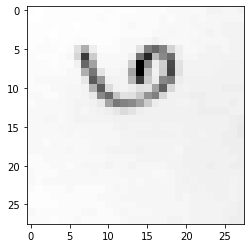

In [ ]:
show_img = dataset[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [ ]:
dataset[1][1]

3

## Dataloader

In [ ]:
'''
MAKING DATASET ITERABLE
'''

# prepare loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [ ]:
image, label = next(iter(val_loader))
image.shape, label.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [ ]:
# torch.flatten(image,1,3).shape
# image.view(image.shape[0], -1).shape

torch.Size([20, 784])

# FCN Model

In [ ]:
class FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)    #Input Layer
        self.fc2 = nn.Linear(512, 256)          #Hidden Layer
        self.fc3 = nn.Linear(256, 128)          #Hidden Layer
        self.fc4 = nn.Linear(128, num_classes)   #Output Layer

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        # probas = F.log_softmax(self.fc4(x), dim=1)
        logits = self.fc4(x)
        
        return logits

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''

model = FC(input_size=input_shape, num_classes=output_shape)

# To enable GPU
model.to(device)

FC(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Optimizer and Loss Function

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion1 = nn.CrossEntropyLoss()

## Batch Size, Epochs, Iterations

In [ ]:
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 51


# ConvNets

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # input_shape = 1X28X28
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.conv1 = nn.Conv2d(1, 10, 5) #output: 10X24X24
        #torch.nn.MaxPool2d(kernel_size, stride=None)
        self.pool1 = nn.MaxPool2d(2, 2) #output: 10X12X12
        self.conv2 = nn.Conv2d(10, 20, 5) #output: 20X8X8
        self.pool2 = nn.MaxPool2d(2, 2) #output: 20X4X4
        self.fc1 = nn.Linear(20 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''

model2 = ConvNet(num_classes=output_shape)

# To enable GPU
model2.to(device)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)
criterion2 = nn.CrossEntropyLoss()

In [ ]:
num_batches = (len(train_idx) / batch_size)
num_epochs = num_iters / num_batches
num_epochs = int(num_epochs)

print(f'Total Epochs: {num_epochs}')

Total Epochs: 51


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_idx), 'val': len(val_idx)}

# Training

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    all_train_loss = []
    all_val_loss = []
    all_train_acc = []
    all_val_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(0, num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        
                        loss.backward() #calculate gradients
                        optimizer.step() # weights_update 
                        optimizer.zero_grad() #prevents of accumulation gradients

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              all_train_loss.append(epoch_loss)
              all_train_acc.append(epoch_acc.item())
            elif phase == 'val':
              all_val_loss.append(epoch_loss)
              all_val_acc.append(epoch_acc.item())              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plotting the training and validation loss
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(all_train_loss, label='Training loss')
    axs[0].plot(all_val_loss, label='Validation loss')
    axs[0].set_label("Training VS. Validation Loss")
    axs[0].set(xlabel="Epochs", ylabel="Loss")
    # plotting the training and validation accuracy
    axs[1].plot(all_train_acc, label='Training accuracyc')
    axs[1].plot(all_val_acc, label='Validation accuracy')
    axs[1].set_label("Training VS. Validation Accuracy")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy")

    axs[0].legend()
    axs[1].legend()

    # fig.tight_layout()
    plt.show()    
    return model

### Training FCN

Epoch 0/24
----------
train Loss: 2.3029 Acc: 0.0986
val Loss: 2.2986 Acc: 0.0959

Epoch 1/24
----------
train Loss: 2.2846 Acc: 0.1279
val Loss: 2.2613 Acc: 0.1343

Epoch 2/24
----------
train Loss: 2.1563 Acc: 0.2078
val Loss: 2.0713 Acc: 0.2365

Epoch 3/24
----------
train Loss: 2.0019 Acc: 0.2811
val Loss: 1.9393 Acc: 0.3089

Epoch 4/24
----------
train Loss: 1.9085 Acc: 0.3174
val Loss: 1.8787 Acc: 0.3462

Epoch 5/24
----------
train Loss: 1.8038 Acc: 0.3747
val Loss: 1.7419 Acc: 0.3774

Epoch 6/24
----------
train Loss: 1.6849 Acc: 0.4142
val Loss: 1.5825 Acc: 0.4731

Epoch 7/24
----------
train Loss: 1.5291 Acc: 0.4797
val Loss: 1.5865 Acc: 0.4340

Epoch 8/24
----------
train Loss: 1.4831 Acc: 0.4878
val Loss: 1.3507 Acc: 0.5467

Epoch 9/24
----------
train Loss: 1.3907 Acc: 0.5299
val Loss: 1.2972 Acc: 0.5812

Epoch 10/24
----------
train Loss: 1.3202 Acc: 0.5556
val Loss: 1.3073 Acc: 0.5464

Epoch 11/24
----------
train Loss: 1.2091 Acc: 0.6044
val Loss: 1.2968 Acc: 0.5495

Ep

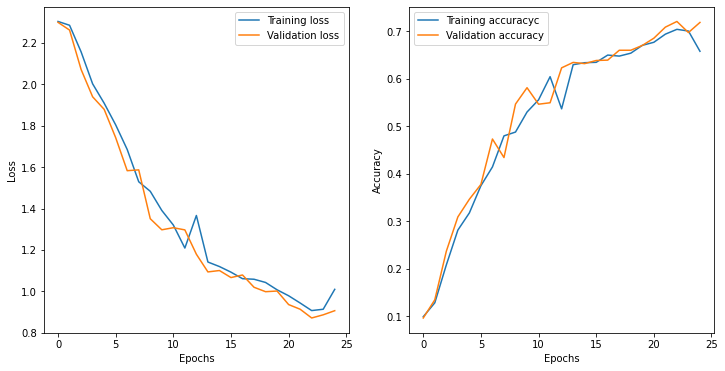

In [ ]:
model = train_model(model, criterion1 , optimizer1, num_epochs=25, name="fc")

### Training ConvNet

In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/PyTorch Tutorial/fc.pth")

torch.save(model2.state_dict(), "drive/MyDrive/PyTorch Tutorial/conv.pth")

In [ ]:
ls

dataset/  drive/  sample_data/


Epoch 0/24
----------
train Loss: 2.2490 Acc: 0.1615
val Loss: 2.0668 Acc: 0.2632

Epoch 1/24
----------
train Loss: 1.8300 Acc: 0.3337
val Loss: 1.6356 Acc: 0.4391

Epoch 2/24
----------
train Loss: 1.5177 Acc: 0.4543
val Loss: 1.3887 Acc: 0.5198

Epoch 3/24
----------
train Loss: 1.2727 Acc: 0.5583
val Loss: 1.2177 Acc: 0.5916

Epoch 4/24
----------
train Loss: 1.1141 Acc: 0.6105
val Loss: 1.0260 Acc: 0.6558

Epoch 5/24
----------
train Loss: 0.9647 Acc: 0.6659
val Loss: 0.9449 Acc: 0.6855

Epoch 6/24
----------
train Loss: 0.8537 Acc: 0.7092
val Loss: 0.8137 Acc: 0.7294

Epoch 7/24
----------
train Loss: 0.7958 Acc: 0.7292
val Loss: 0.8531 Acc: 0.7025

Epoch 8/24
----------
train Loss: 0.7630 Acc: 0.7401
val Loss: 0.7989 Acc: 0.7277

Epoch 9/24
----------
train Loss: 0.7069 Acc: 0.7619
val Loss: 0.7030 Acc: 0.7660

Epoch 10/24
----------
train Loss: 0.6520 Acc: 0.7870
val Loss: 0.6355 Acc: 0.7990

Epoch 11/24
----------
train Loss: 0.6163 Acc: 0.7962
val Loss: 0.6088 Acc: 0.8046

Ep

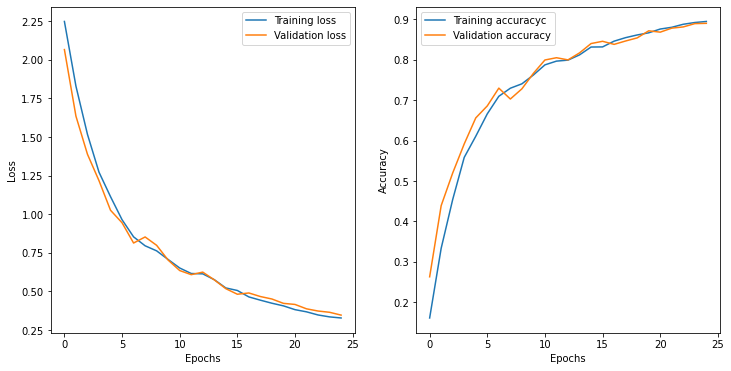

In [ ]:
model2 = train_model(model2, criterion2, optimizer2, num_epochs=25, name="conv")

## Evaluating Classwise Performance

In [ ]:
classes = np.arange(0,10)

## FCN

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 72.08121827411168 %
Accuracy of 0: 64.37994722955145 %
Accuracy of 1: 63.75661375661376 %
Accuracy of 2: 67.5233644859813 %
Accuracy of 3: 81.13207547169812 %
Accuracy of 4: 88.04878048780488 %
Accuracy of 5: 71.2401055408971 %
Accuracy of 6: 95.90361445783132 %
Accuracy of 7: 75.97911227154047 %
Accuracy of 8: 71.25307125307125 %
Accuracy of 9: 39.743589743589745 %


## ConvNet

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 88.95939086294416 %
Accuracy of 0: 86.01583113456465 %
Accuracy of 1: 80.68783068783068 %
Accuracy of 2: 88.08411214953271 %
Accuracy of 3: 89.21832884097034 %
Accuracy of 4: 96.82926829268293 %
Accuracy of 5: 92.87598944591029 %
Accuracy of 6: 93.25301204819277 %
Accuracy of 7: 93.21148825065274 %
Accuracy of 8: 88.94348894348894 %
Accuracy of 9: 79.74358974358974 %


# Inference

In [ ]:
test_images[0]

NameError: ignored

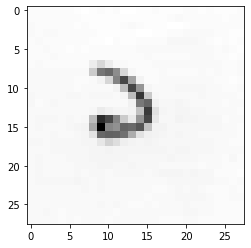

In [ ]:
import glob
i=3
test_images = glob.glob(TEST_PATH+"/*")
img = Image.open(test_images[i]).convert('L')
img = transform(img)
plt.imshow(img.reshape(28,28), cmap='gray')

In [ ]:
model = torch.load("/content/drive/MyDrive/PyTorch Tutorial/fc.pth",map_location=device)

In [ ]:
prediction = model(img.view(-1, 28*28).to(device))
prediction = torch.argmax(prediction, dim=1)
print('Predicted label', prediction.cpu().numpy())

NameError: ignored

In [ ]:
prediction2 = model2(img.view(-1, 28*28).to(device))
prediction2 = torch.argmax(prediction2, dim=1)
print('Predicted label', prediction2.cpu().numpy())

In [ ]:
import torch
import torch.nn as nn

''' 3 DIFFERENT METHODS TO REMEMBER:
 - torch.save(arg, PATH) # can be model, tensor, or dictionary
 - torch.load(PATH)
 - torch.load_state_dict(arg)
'''

''' 2 DIFFERENT WAYS OF SAVING
# 1) lazy way: save whole model
torch.save(model, PATH)

# model class must be defined somewhere
model = torch.load(PATH)
model.eval()

# 2) recommended way: save only the state_dict
torch.save(model.state_dict(), PATH)

# model must be created again with parameters
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
'''



model = FC(input_shape, output_shape)


####################save all ######################################
for param in model.parameters():
    print(param)

# save and load entire model

FILE = "model.pth"
torch.save(model, FILE)

loaded_model = torch.load(FILE)
loaded_model.eval()

for param in loaded_model.parameters():
    print(param)


############save only state dict #########################

# save only state dict
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

print(model.state_dict())
loaded_model = FC(input_shape, output_shape)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

print(loaded_model.state_dict())


###########save & load checkpoint#####################
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

checkpoint = {
"epoch": 90,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
print(optimizer.state_dict())
FILE = "checkpoint.pth"
torch.save(checkpoint, FILE)

model = Model(n_input_features=6)
optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0)

checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

model.eval()
# - or -
# model.train()

print(optimizer.state_dict())

# Remember that you must call model.eval() to set dropout and batch normalization layers 
# to evaluation mode before running inference. Failing to do this will yield 
# inconsistent inference results. If you wish to resuming training, 
# call model.train() to ensure these layers are in training mode.

In [ ]:
""" SAVING ON GPU/CPU 

# 1) Save on GPU, Load on CPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))

# 2) Save on GPU, Load on GPU
device = torch.device("cuda")
model.to(device)
torch.save(model.state_dict(), PATH)

model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)

# Note: Be sure to use the .to(torch.device('cuda')) function 
# on all model inputs, too!

# 3) Save on CPU, Load on GPU
torch.save(model.state_dict(), PATH)

device = torch.device("cuda")
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)

# This loads the model to a given GPU device. 
# Next, be sure to call model.to(torch.device('cuda')) to convert the model’s parameter tensors to CUDA tensors
"""